In [176]:
from PIL import Image
import os
import matplotlib.pyplot as plt

import numpy as np
import torch
from torchmetrics.image import (PeakSignalNoiseRatio,
                                StructuralSimilarityIndexMeasure,
                                VisualInformationFidelity)
from torchvision import transforms
from tqdm import tqdm

from models.unet import UNet

In [177]:
def load_checkpoint(model, checkpoint: str):
    model.load_state_dict(torch.load(checkpoint))


def predict(model, device, image_path):
    image = Image.open(image_path).convert('L')
    image = transforms.ToTensor()(image).unsqueeze(0)
    image = image.to(device)
    out = model(image)
    out_image = transforms.ToPILImage()(out.squeeze(0))

    return out_image, out

In [225]:
curr_dir = os.getcwd()

checkpoint = os.path.join(curr_dir, "test_contrast_inverted.pth")
image_dir = os.path.join(curr_dir, "data/test_train_images/test/data")
gt_dir = os.path.join(curr_dir, "data/test_train_images/test/gt")

In [179]:
images = os.listdir(image_dir)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet()
model = model.to(DEVICE)
model.eval()

load_checkpoint(model, checkpoint=checkpoint)

In [180]:
import random

In [181]:
random.seed(1022)
random_samples = random.sample(images, 3)

In [182]:
random_samples

['150_CC0133_siemens_15_64_F.jpg',
 '164_CC0259_ge_15_56_F.jpg',
 '173_CC0072_philips_3_31_M.jpg']

In [183]:
base_images = []

# Load gt
for sample in random_samples:
    image_path = os.path.join(image_dir, sample)
    image = Image.open(image_path).convert('L')
    base_images.append((image, transforms.ToTensor()(image).unsqueeze(0)))

In [184]:
base_images[0][1].shape

torch.Size([1, 1, 288, 256])

In [185]:
gts = []

# Load gt
for sample in random_samples:
    image_path = os.path.join(gt_dir, sample)
    image = Image.open(image_path).convert('L')
    gts.append((image, transforms.ToTensor()(image).unsqueeze(0)))

In [186]:
gts[0][1].shape

torch.Size([1, 1, 288, 256])

In [187]:
preds = []

for image in tqdm(random_samples):
    predicted = predict(model, DEVICE, os.path.join(image_dir, image))
    preds.append(predicted)

100%|██████████| 3/3 [00:00<00:00, 159.31it/s]


In [188]:
preds[0][1].shape

torch.Size([1, 1, 288, 256])

In [189]:
metrics = {
    "PSNR": PeakSignalNoiseRatio().to(DEVICE),
    "SSIM": StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE),
    "VIF": VisualInformationFidelity().to(DEVICE)
}

In [218]:
from PIL import Image, ImageDraw, ImageFont

# Define a function to overlay text on a PIL image
def overlay_text_pil(image, text, position, color=(255, 255, 255), font_path=None, font_size=15):
    if image.mode != 'RGBA':
        image = image.convert('RGBA')

    draw = ImageDraw.Draw(image)

    if font_path is None:
        font = ImageFont.load_default(font_size)
    else:
        font = ImageFont.truetype(font_path, font_size)

    draw.text(position, text, fill=color, font=font)

    return image

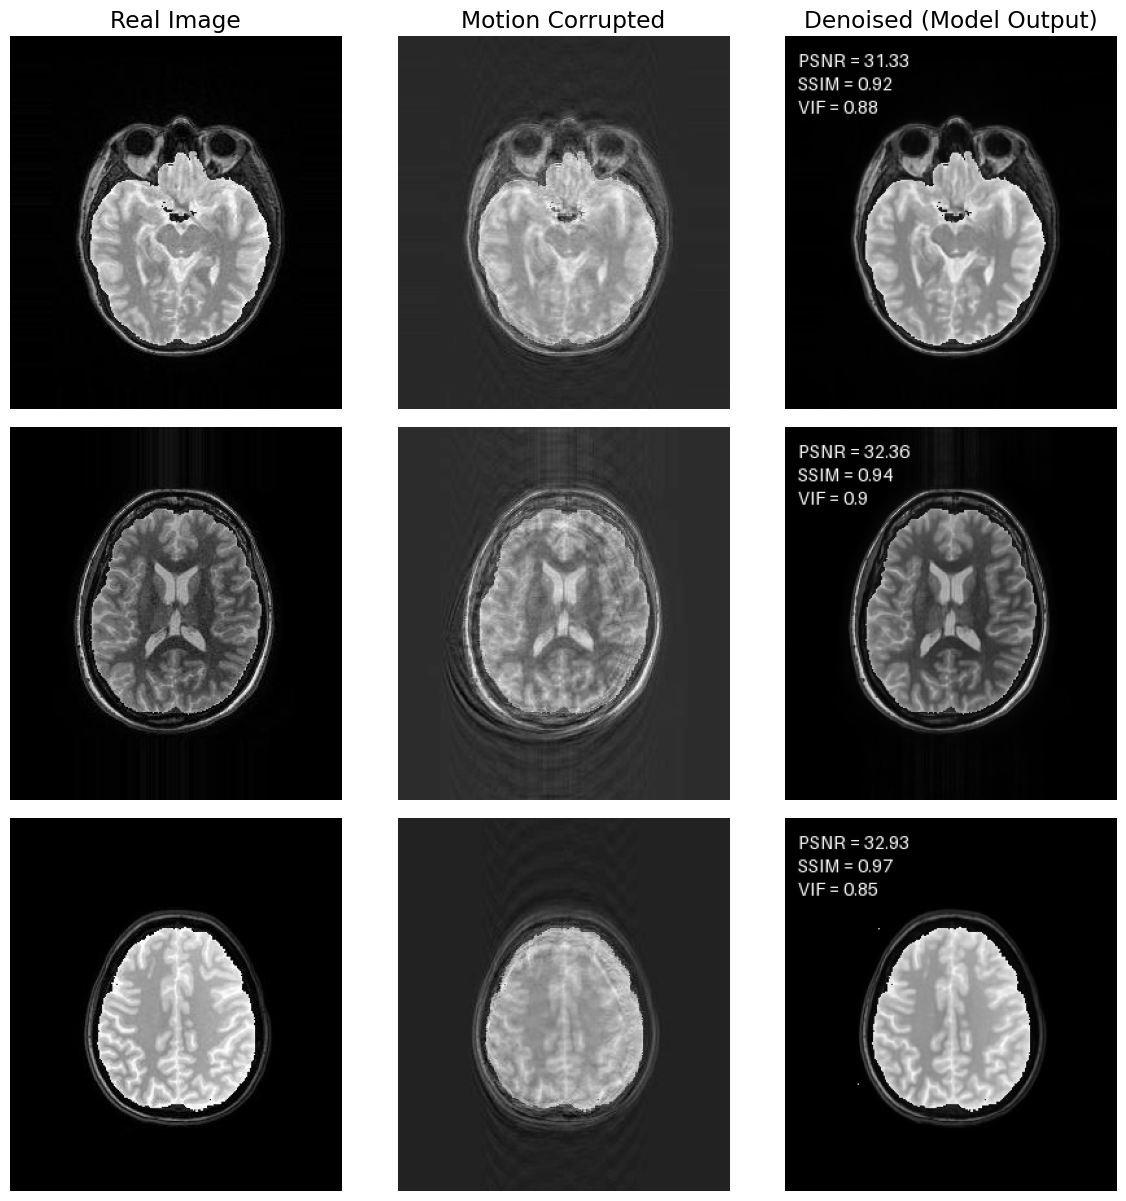

In [224]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 14, 'axes.titlesize': 'large', 'axes.labelsize': 'medium'})

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
plt.subplots_adjust(wspace=0.0, hspace=0.05)

axs[0, 0].set_title('Real Image')
axs[0, 1].set_title('Motion Corrupted')
axs[0, 2].set_title('Denoised (Model Output)')

for enum_index, (base, gt, pred) in enumerate(zip(base_images, gts, preds)):
    scores = {}
    for metric_name, metric_fn in metrics.items():
        scores[metric_name] = metric_fn(pred[1].cpu(), gt[1].cpu()).cpu().detach().numpy()

    result = "\n".join([f"{key} = {np.round(value.item(), decimals=2)}" for key, value in scores.items()])
    
    axs[enum_index][0].imshow(gt[0], cmap="gray")
    axs[enum_index][1].imshow(base[0], cmap="gray")
    # axs[enum_index][2].imshow(pred[0], cmap="gray")

    # Overlay text on the denoised image
    pred_img_with_text = overlay_text_pil(pred[0], result, (10, 10), color=(255, 255, 255), font_size=14)

    axs[enum_index][2].imshow(pred_img_with_text, cmap="gray")

for ax in axs:
    for subax in ax:
        subax.axis('off')

plt.show()
